In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import requests
import json
import time
from pandas.io.json import json_normalize
import xml.etree.ElementTree as ET
import helpers as helpers

# Content-base filtering méthode

## Objectif

* Vectoriser les données bibliographiques à l'aide de méthodes de data science pour calculer les distances cosinus (comme indicateurs de similarité) pour chaque paire de documents

* Produire une fonction

## Dataframe des données

**Fichier initial data/export_SJA.csv : export ARC (module stat Aleph) de tous les exemplaires de la BU SJA**

In [3]:
df = pd.read_csv('data/01_raw/sja_tous_exemplaires.csv', sep = ';')
df.shape ## 35085 lignes et 10 colonnes

(35085, 10)

In [4]:
df.head(2)

,Desc Bibliothèque,Desc Statut Exemplaire,ID Statut Exemplaire,Titre,No de Notice BIB,Desc4,Desc5,Auteur,Date Publication,Desc Format
0,BU St-Jean,En rayon,19,La^Théorie des jeux,222086,PPN000117307,PPN000117307,"Plon, Michel",1976,Books
1,BU St-Jean,En rayon,19,Théorie des jeux pour l'économie et la politique,217008,PPN000494410,PPN000494410,"Moulin, Hervé (1950-....)",1981,Books


In [ ]:
On supprime les colonnes inutiles et on renomme les autres

In [5]:
df.drop(['Desc Bibliothèque', 'Desc Statut Exemplaire', 'Desc5', 'ID Statut Exemplaire', 'Desc Format'], axis = 1, inplace = True)
df.columns = ['titre', 'num', 'ppn', 'auteur', 'date']

Comme on ne travaille que sur les données bibliographiques et que la source est un fichier d'exemplaires, on dédoublonne les items sur le numéro d'identification Aleph

Pour voir les doublons

In [ ]:
df.sort_values("num").head(10)

Pour les supprimer

In [6]:
df.drop_duplicates(subset ="num", keep = False, inplace = True)
## 33062 lignes

In [7]:
df.shape

(33062, 5)

## Caractéristiques du dataset

In [ ]:
df.describe(include = 'all')

Focus sur les valeurs manquantes (que l'on calcule avec une fonction spécifique)

In [8]:
helpers.missing_zero_values_table(df)

Your selected dataframe has 5 columns and 33062 Rows.
There are 2 columns that have missing values.


,Zero Values,Missing Values,% of Total Values,Total Zero Missing Values,% Total Zero Missing Values,Data Type
auteur,0,5376,16.3,5376,16.3,object
ppn,0,78,0.2,78,0.2,object


## Nettoyage des données

### Champ PPN

On repère les valeurs manquantes

In [9]:
df[df.ppn.isnull()].head(2)

,titre,num,ppn,auteur,date
230,Dermatologie. Toute la dermatologie en 1774 qu...,430376,NaN,Hamroun Sabrina,2019
313,Endocrinologie-Diabétologie-Nutrition 9ème édi...,425643,NaN,NaN,0


78 notices concernées (0,2% du total), on supprime les lignes

In [10]:
df.dropna(subset=['ppn'], inplace = True) ## 32984 lignes

In [11]:
df.shape

(32984, 5)

In [ ]:
On supprime le préfixe PPN devant les valeurs

In [12]:
df['ppn'] =  [re.sub(r'PPN','', str(x)) for x in df['ppn']]

In [ ]:
On vérifie les valeurs

In [ ]:
df.ppn.unique()

In [ ]:
Car par exemple on peut identifier des OCN à la place de ppn

In [ ]:
df[df.ppn.str.contains('OCN', regex= True, na=False)]

### Champ Titre

Pas de champs vides mais un caractère (^) spécifique aux exports Arc du champ titre : à nettoyer

In [13]:
df['titre'] =  [re.sub('\^',' ',str(x)) for x in df['titre']]

Pour la transformation en vecteur de termes, on nettoie le champ en supprimant la ponctuation et mettant tout les caractères en minsucules

In [14]:
df['titre'] = [helpers.clean_ponctuation_lowercase(str(x)) for x in df['titre']]

On visualise les valeurs uniques (qui donne une idée de la proportion de titres "génériques")

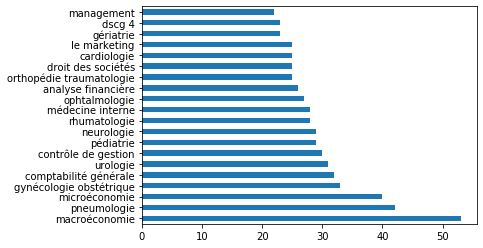

In [15]:
df['titre'].value_counts()[:20].plot(kind='barh')

### Champ Date

In [16]:
df.date.describe()

count    32984.000000
mean      2093.240147
std        886.335755
min          0.000000
25%       1990.000000
50%       2001.000000
75%       2009.000000
max       9999.000000
Name: date, dtype: float64

On remarque 2 outliers (valeurs extrèmes) pour le champ Date : 0 et 9999, qui faussent la moyenne et les quartiles

In [18]:
df['num'].loc[df.date == 0].count() ## 37

37

In [19]:
df['num'].loc[df.date == 9999].count() ## 407

407

On corrige ces valeurs en les remplacant par la médiane

In [20]:
df.loc[(df.date == 0) | (df.date == 9999), 'date'] = np.nan
df.date = df.date.fillna(df.date.median())
df.date = df.date.astype(np.int32)

On vérifie toutes les valeurs

In [ ]:
sorted(df.date.unique())

et de nouveau les métriques après corrections

In [21]:
df.date.describe()
## Moyenne : 1996
## Médiane : 2001
## 75% : 2008

count    32984.000000
mean      1996.794931
std         15.649084
min       1854.000000
25%       1990.000000
50%       2001.000000
75%       2008.000000
max       2019.000000
Name: date, dtype: float64

Graphique de répartition des notices par date

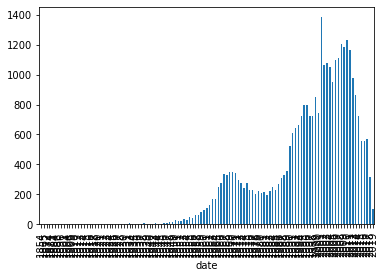

In [22]:
df.groupby('date')['date'].count().plot.bar()
plt.rcParams["figure.figsize"] = (24, 9)
plt.tick_params(axis='x', labelrotation=90)

### Champ auteur

In [ ]:
df[df.auteur.isnull()]
## 5376 valeurs manquantes soit 16,3%

On les replace par des champs vides

In [ ]:
df['auteur'] = df['auteur'].fillna('')

Comme pour le champ titre, on nettoie les valeurs avec la même fonction

In [ ]:
df['auteur'] = [helpers.clean_ponctuation_lowercase(str(x)) for x in df['auteur']]

Et on applique un traitement supplémentaire de concaténation des chaines de caractères, nécessaire pour que le calcul de similarité s'effectue sur la forme normalisée concaténée et non sur des prénoms isolés par exemple

In [ ]:
def concat_data(x):
    if isinstance(x, list):
        return [str(i.replace(" ", "")) for i in x]
    else:
        if isinstance(x, str):
            return str(x.replace(" ", ""))
        else:
            return ''

df["auteur"] = df["auteur"].apply(concat_data)

## Enrichissement des données

### Indexation

On applique une fonction qui récupère les points d'accès sujets de la notice Sudoc en interrogeant l'APi Unimarc/xml avec le ppn en paramètre

In [ ]:
def get_rameau(row):
    try:
        url = 'https://www.sudoc.fr/' + str(row['ppn'])  + '.xml'        
        response = (requests.get(url).text)
        responseXml = ET.fromstring(response)
        return [result.text for result in responseXml.findall("./datafield[@tag='606']/subfield[@code='a']")]
    
    except:
        pass
        
df['indexation'] = df.apply(get_rameau, axis=1) 

In [ ]:
df.indexation.describe()
df.indexation.head(5)

Toutes les notices sont indexées mais 

* les valeurs se présentent sous forme de tableaux stockés comme des chaines de caractères
* certains points d'accès doublonnent (notamment lors d'une double indaxtion Rameau/LCC par exemple)

il faut donc "destringifier" les tableaux, en supprimer les doublons puis les décomposer en chaines de caractères concaténées

In [ ]:
df['indexation_clean_dedup'] = df['indexation'].apply(lambda x : ";".join(np.unique([str.lower(word).strip().replace("d'","").replace("'",'').replace('"','') for word in x])))

On vérifie la nouvelle colonne

In [ ]:
df.indexation_clean_dedup.head(20)
## game theory;sciences sociales;social sciences;...
## economics;game theory;political science;politi...
## algorithmes;informatique;mathématiques;turbo p...

### [Non appliqué] Nombre de localisations

On pourrait également compléter les données en ajoutant le nombre de localisations Sudoc pour chaque notice (pour par exemple servir de paramètre de tri dans l'affichage des recommandations)

In [ ]:
def get_multiwhere(row):
    if str(row['ppn1']).isdigit():
        try:
            url = 'http://www.sudoc.fr/services/multiwhere/' + str(row['ppn'])  + '&format=text/json'        
            response = (requests.get(url).text)
            response_json = json.loads(response)
            time.sleep(0.5)
            return len(response_json['sudoc']['query']['result']['library'])    
        except:
            pass
    else:
        pass
    
df['locs'] = df.apply(get_multiwhere, axis=1)

## Calcul de la similarité

### création de la "soupe de données"

On concatène les champs titre-auteur-indexation en une liste d'occurences dans une nouvelle colonne

In [ ]:
def create_all_metadata(x):
    return str(x["titre"]).strip() + " " + str(x["auteur"]).strip() + " " + str(x["indexation_clean_dedup"]).strip()
df['all_metadata'] = df.apply(create_all_metadata, axis=1)

On importe la librairie dédiée au text mining et ses dictionnaires de stopwords

In [ ]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

On exclue les stopwords (mots n'ayant pas de signification : articles, adverbes...) en français et en anglais
Pour le français on exclue aussi "l'" et "d'" qui ne font pas partie de la liste stopwords français de nlkt

*stopwords.words('french').extend(["l'","d'"]) ne marche pas*


In [ ]:
stop_fr = stopwords.words('french')
df['metadata_stop_fr'] = df['all_metadata'].apply(lambda x: ' '.join([word.replace("l'","").replace("d'","")
stop_en = stopwords.words('english')    
df['metadata_stop_fr_en'] = df['metadata_stop_fr'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_en)]))

In [ ]:
df['metadata_stop_fr_en']

### Sauvegarde

In [ ]:
df.to_csv("data/05_model_input/exemplaires_sja_nltk_complete.csv", sep = ';', index=False, encoding='utf8')

### CountVectorizer (méthode choisie)

In [3]:
## import de la classe CountVectorizer de la bibliothèque de ML scikit-learn
from sklearn.feature_extraction.text import CountVectorizer

In [4]:
## on crée l'objet CountVectorizer
count = CountVectorizer()
## méthode fit_transform pour générer la mtrice
count_matrix = count.fit_transform(df['metadata_stop_fr_en'])
count_matrix.shape

(32981, 39627)

#### TfidVectorizer (autre possibilité)

In [ ]:
## import de la classe TfidfVectorizer de la bibliothèque de ML scikit-learn
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
## on crée l'objet TfidfVectorizer
tfidf = TfidfVectorizer()
## méthode fit_transform pour générer la mtrice
tfidf_matrix = tfidf.fit_transform(df['metadata_stop_fr_en'])
tfidf_matrix.shape

### Fonction de calcul de similarité cosinus

In [5]:
## import de la fonction de calcul de la distance cosinus de la bibliothèque de ML scikit-learn
from sklearn.metrics.pairwise import cosine_similarity
## pour la sérialisation du modèle et le pipeline de data
import joblib

In [7]:
cosine_sim = cosine_similarity(count_matrix, count_matrix)
## sauvegarde du modèle
joblib.dump(cosine_sim, 'data/06_models/model.pkl', compress=4)

['model.pkl']

In [ ]:
## et enfin la fonction qui fournit les 10 documents les plus proches
indices = pd.Series(df.index, index=df['num']).drop_duplicates()
def getRecommendations(num, cosine_sim=cosine_sim):
    idx = indices[num]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:11]
    item_indices = [i[0] for i in sim_scores]
    return df['titre'].iloc[item_indices]